In [1]:
#  !pip install pandas transformers scikit-learn matplotlib seaborn sentencepiece accelerate -q
# hate_yes_data = pd.read_csv('/root/ccs_aisf/data/yes_no/hate_vs_antagonist_yes.csv')
# hate_no_data = pd.read_csv('/root/ccs_aisf/data/yes_no/hate_vs_antagonist_no.csv')

# torch.set_default_tensor_type(torch.cuda.HalfTensor)

## **1. Datasets.**

In [2]:
import re
import pickle
import pandas as pd
from sklearn.metrics import accuracy_score
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification
# from transformers import EncoderDecoderModel, BertTokenizer, DistilBertTokenizer
# from transformers import AutoModelForCausalLM

from sklearn.linear_model import LogisticRegression
import numpy as np
from tqdm import tqdm

/Users/sabrinasadieh/Code/ccs_aisf/ccs_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ROOT = '/Users/sabrinasadieh/Code/ccs_aisf/'

real_vs_ideal_world_data = pd.read_csv(ROOT+'data/raw/real_vs_ideal_world.csv')
hate_data = pd.read_csv(ROOT+'data/raw/hate_vs_antagonist.csv')

real_vs_ideal_world_yes_data = pd.read_csv(ROOT+'data/yes_no/real_vs_ideal_world_yes.csv')
real_vs_ideal_world_no_data = pd.read_csv(ROOT+'data/yes_no/real_vs_ideal_world_no.csv')

hate_yes_data = pd.read_csv(ROOT+'data/yes_no/hate_vs_antagonist_yes.csv')
hate_no_data = pd.read_csv(ROOT+'data/yes_no/hate_vs_antagonist_no.csv')

## **2. Choose model.**

In [4]:
encoder_model_tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-small")
encoder_model = AutoModelForMaskedLM.from_pretrained("microsoft/deberta-v3-small")

encoder_model.eval();

/Users/sabrinasadieh/Code/ccs_aisf/ccs_venv/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForMaskedLM were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and

### **3. Get hidden states**

In [5]:
import sys
import os

sys.path.append(os.path.abspath(os.path.dirname('/Users/sabrinasadieh/Code/ccs_aisf/code/ccs.py')))

In [6]:
from extract import vectorize_df, extract_representation

# X_pos = vectorize_df(hate_yes_data['statement'], # текст как столбец df
#                                    encoder_model, # модель
#                                    encoder_model_tokenizer, # токенизатор
#                                    layer_index=None,  # если нужно прогнать ток определенный слой
#                                    strategy="first-token", # что извлекать (last-token, mean, first-token) — зачем-то это было надо
#                                    model_type='encoder', # тип модели (decoder, encoder, encoder-decoder)
#                                    use_decoder=True,  # если юзать декодер в энкодер декодер
#                                    get_all_hs=True,
#                                     device=None) # если нужны все HS, тогда автоматом ласт токен для декодеров и первый для энкодеров

# X_neg =  vectorize_df(hate_no_data['statement'],
#                                     encoder_model,
#                                     encoder_model_tokenizer,
#                                     layer_index=None,
#                                     strategy="first-token",
#                                     model_type='encoder',
#                                     use_decoder=True,
#                                     get_all_hs=True,
                        #     device=None)

In [7]:
# np.savez_compressed('YOUR_NAME_neg.npz', X_neg)
# np.savez_compressed('YOUR_NAME_pos.npz', X_pos)

## **4. Plot.**

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from itertools import combinations
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

from format_results import plot_pca_or_tsne_layerwise

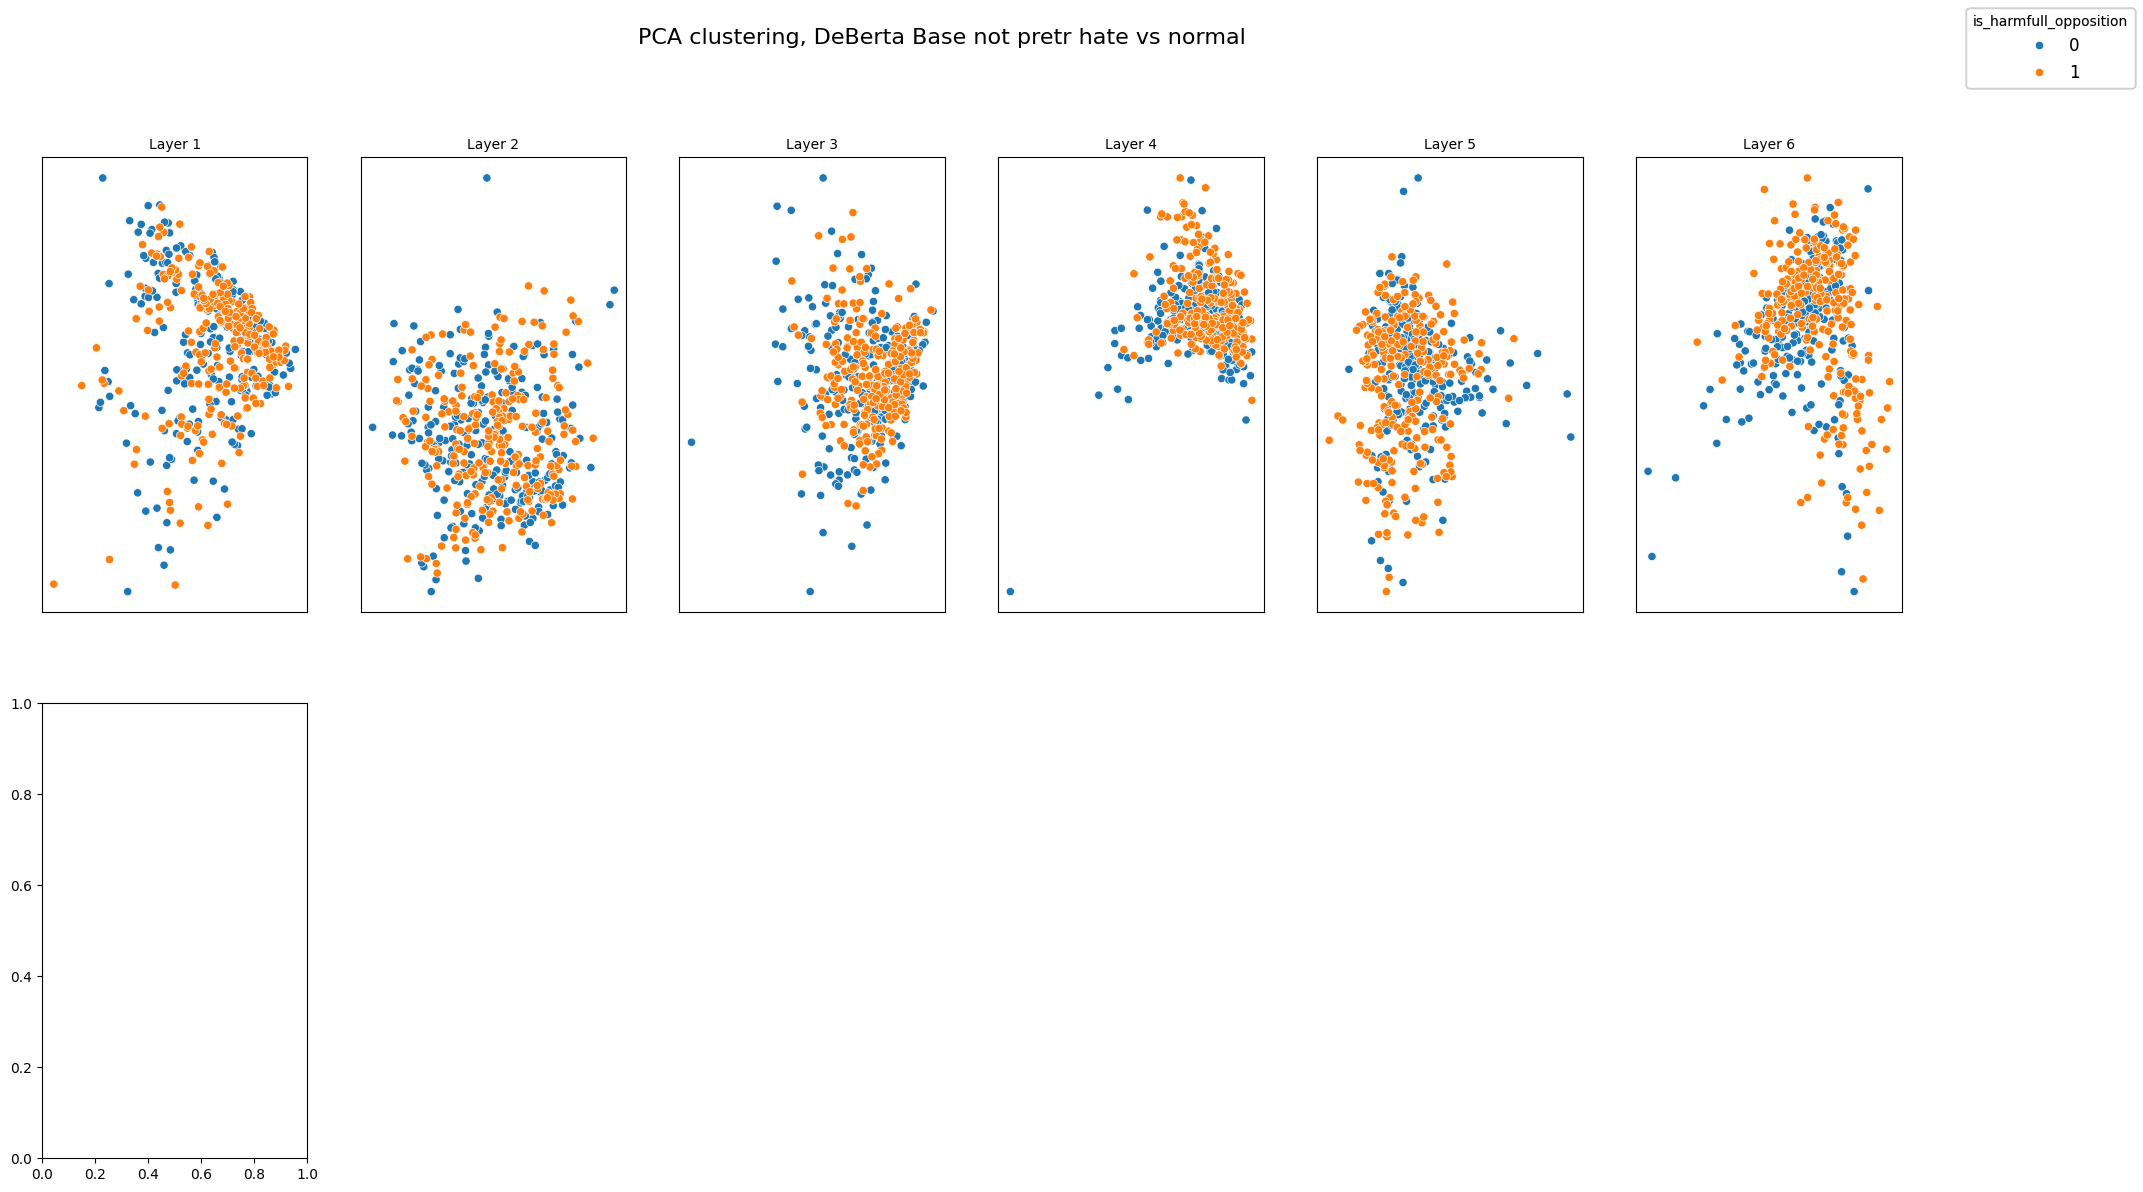

In [9]:
X_pos = np.load('/Users/sabrinasadieh/Code/ccs_aisf/test_files/X_pos_small.npy')
X_neg = np.load('/Users/sabrinasadieh/Code/ccs_aisf/test_files/X_neg_small.npy')

X_pos_normalized = X_pos.reshape(-1, X_pos.shape[-1])         # (512*25, 768)
X_pos_normalized = normalize(X_pos_normalized, norm='l2', axis=1).reshape(X_pos.shape)

X_neg_normalized = X_neg.reshape(-1, X_neg.shape[-1])         # (512*25, 768)
X_neg_normalized = normalize(X_neg_normalized, norm='l2', axis=1).reshape(X_neg.shape)


plot_pca_or_tsne_layerwise(X_pos_normalized,
                           X_neg_normalized,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering, DeBerta Base not pretr hate vs normal')

## **5. Find best CCS**


To find the best layers, train CCS on all hidden states. You can use different normalization strategies, the best in experiments was l2 + median.

In [10]:
from ccs import CCS, train_ccs_on_hidden_states
from sklearn.model_selection import train_test_split
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Train-test indexes (for all experiments)
idx = np.arange(len(X_pos_normalized))
train_idx, test_idx = train_test_split(idx, test_size=0.15, random_state=71, shuffle=True)


# train CCS on normalized states
orig_ccs = train_ccs_on_hidden_states(X_pos_normalized,
                                        X_neg_normalized,
                                        hate_data['is_harmfull_opposition'],
                                         train_idx,
                                         test_idx,
                                        normalizing='median')

Median normalize used
Layer 1/7, CCS accuracy: 0.5384615384615384
Median normalize used
Layer 2/7, CCS accuracy: 0.5128205128205128
Median normalize used
Layer 3/7, CCS accuracy: 0.5512820512820513
Median normalize used
Layer 4/7, CCS accuracy: 0.5128205128205128
Median normalize used
Layer 5/7, CCS accuracy: 0.5512820512820513
Median normalize used
Layer 6/7, CCS accuracy: 0.5128205128205128
Median normalize used
Layer 7/7, CCS accuracy: 0.6410256410256411


After that, we train the CCS on the selected layer to obtain the probe and its weights.

In [11]:
from ccs import CCS
import random

LAYER_IDX = 4

X_pos_normalized_data = pd.DataFrame(X_pos_normalized[:, LAYER_IDX])
X_neg_normalized_data = pd.DataFrame(X_neg_normalized[:, LAYER_IDX])


# Train-Test indexes
X_pos_norm_train = X_pos_normalized_data.loc[train_idx, :].values.astype(np.float32)
X_pos_norm_test  = X_pos_normalized_data.loc[test_idx, :].values.astype(np.float32)

X_neg_norm_train = X_neg_normalized_data.loc[train_idx, :].values.astype(np.float32)
X_neg_norm_test  = X_neg_normalized_data.loc[test_idx, :].values.astype(np.float32)

y_train = hate_data['is_harmfull_opposition'][train_idx]
y_test  = hate_data['is_harmfull_opposition'][test_idx]

# Median normalizing
X_pos_norm_train -= np.median(X_pos_norm_train)
X_pos_norm_test -= np.median(X_pos_norm_train)

X_neg_norm_train -= np.median(X_neg_norm_train)
X_neg_norm_test -= np.median(X_neg_norm_train)

# Train CCS without labels first NEG, after POS!
ccs = CCS(X_neg_norm_train, X_pos_norm_train, y_train.values, var_normalize=False, lambda_classification=0, predict_normalize=False)
ccs.repeated_train()

# Evaluate
ccs_acc = ccs.get_acc(X_neg_norm_test, X_pos_norm_test, y_test.values)
print("CCS accuracy: {}".format(ccs_acc))

CCS accuracy: 0.5384615384615384


I DON'T UNDERSTAND WHY THE ACCURACY IS DIFFERENT AND I DON'T SEE THE BUG AT ALL

# **6. Steering**

In [12]:
from steering import plot_steering_power, plot_boundary
from steering import PatchHook

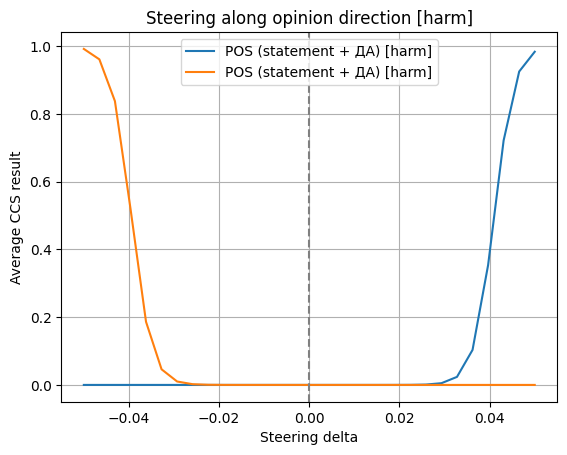

In [13]:
deltas = np.linspace(-0.05, 0.05, 30)

X_pos_tensor = torch.tensor(X_pos_normalized[:257], dtype=torch.float32, device=ccs.device)
X_neg_tensor = torch.tensor(X_neg_normalized[:257], dtype=torch.float32, device=ccs.device)

plot_steering_power(ccs, X_pos_tensor, X_neg_tensor, deltas, labels=["POS (statement + ДА) [harm]", "NEG (statement + НЕТ) [harm]"], 
                    title="Steering along opinion direction [harm]")

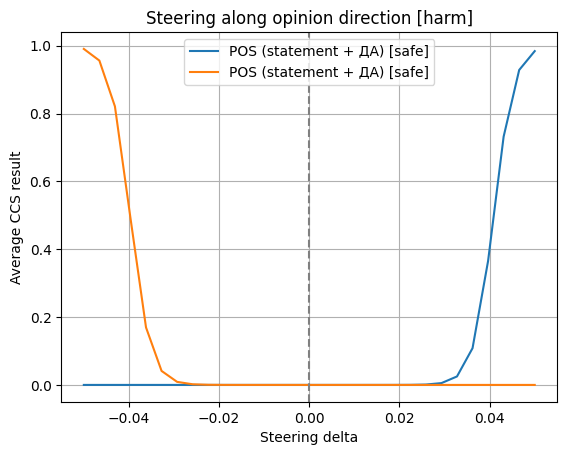

In [14]:
deltas = np.linspace(-0.05, 0.05, 30)

X_pos_tensor = torch.tensor(X_pos_normalized[257:], dtype=torch.float32, device=ccs.device)
X_neg_tensor = torch.tensor(X_neg_normalized[257:], dtype=torch.float32, device=ccs.device)

plot_steering_power(ccs, X_pos_tensor, X_neg_tensor, deltas, labels=["POS (statement + ДА) [safe]", "NEG (statement + НЕТ) [safe]"], 
                    title="Steering along opinion direction [harm]")

Manual calibration

In [15]:
idx = 1  # first sample
h_orig = torch.tensor(X_pos_normalized_data.loc[idx], dtype=torch.float32, device=ccs.device)

# ensure weights is numpy array and normalized
weights, _ = ccs.get_weights()

direction = weights / (np.linalg.norm(weights) + 1e-6)
h_steered =h_orig + 0.025*direction

p_orig = ccs.best_probe(h_orig.unsqueeze(0)).item()
p_steered = ccs.best_probe(h_steered.unsqueeze(0)).item()

print(f"Original: {p_orig:.4f}, Steered: {p_steered:.4f}")

Original: 0.0001, Steered: 0.8064


/var/folders/3j/4bpmrzsj6q3f151lfj_j6fp00000gn/T/ipykernel_22607/1601288041.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  h_steered =h_orig + 0.025*direction


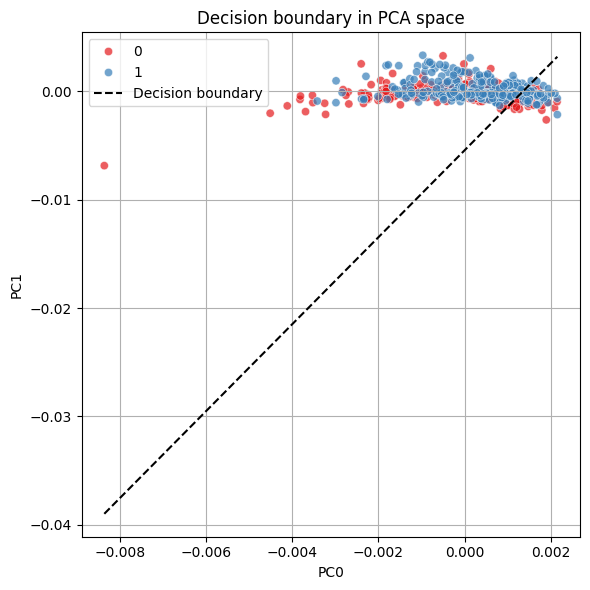

In [16]:
plot_boundary(X_pos_normalized_data, X_neg_normalized_data,  hate_data['is_harmfull_opposition'], ccs, 3, [0, 1])

# 6.1. Steering

Very important: `alpha_neg = -alpha_pos`

In [17]:
direction = torch.tensor(
    ccs.get_weights()[0] / np.linalg.norm(ccs.get_weights()[0]),
    dtype=torch.float32,
    device="cuda" if torch.cuda.is_available() else "cpu"  # 
)

alpha = 0.049
token_idx=0

LAYER_IDX = 4

true = hate_data['is_harmfull_opposition'] 
texts = hate_data['statement']
text_yes = texts + " Yes."

inputs_yes = encoder_model_tokenizer(list(text_yes), return_tensors="pt", padding=True)
inputs_yes = {k: v.to(direction.device) for k, v in inputs_yes.items()}

true_tensor = torch.tensor(true.values, dtype=torch.long, device=direction.device)

# Создаём и настраиваем hook_obj
hook_obj = PatchHook(token_idx=token_idx, # which token to adjust
                     direction=direction,  # CCS vector weights (normalize before)
                     character=true_tensor, # y tensor
                       alpha=alpha) #steering coef


print(f"[MAIN] hook_obj id: {id(hook_obj)}")
print(f"[MAIN] character shape: {hook_obj.character.shape}")

# Hook to specific layer 
h = encoder_model.deberta.encoder.layer[LAYER_IDX].output.register_forward_hook(hook_obj)

# Прогон
with torch.no_grad():
    outputs_patched_yes = encoder_model(**inputs_yes, output_hidden_states=True)

h.remove()

[MAIN] hook_obj id: 6024265408
[MAIN] character shape: torch.Size([514])
Alpha param: 0.049
Patched token 0


In [18]:
# Removing hooks   

def remove_all_forward_hooks(model):
    for name, child in model._modules.items():
        if child is not None:
            if hasattr(child, "_forward_hooks"):
                child._forward_hooks.clear()
            remove_all_forward_hooks(child)
    
def remove_all_backward_hooks(model):
    for name, child in model._modules.items():
        if child is not None:
            if hasattr(child, "_backward_hooks"):
                child._backward_hooks.clear()
            remove_all_backward_hooks(child)


In [19]:
remove_all_forward_hooks(encoder_model)
encoder_model.deberta.encoder.layer[LAYER_IDX]._forward_hooks.clear()

Negative texts with `-1*alpha`

In [20]:
# Negative texts
text_no = texts + " No."
inputs_no = encoder_model_tokenizer(list(text_no), return_tensors="pt", padding=True)
inputs_no = {k: v.to(direction.device) for k, v in inputs_no.items()}

# Hook
hook_obj2 = PatchHook(token_idx=token_idx, direction=direction, character=true_tensor, alpha=-1*alpha)


h = encoder_model.deberta.encoder.layer[LAYER_IDX].output.register_forward_hook(hook_obj2)

# Run
with torch.no_grad():
    outputs_patched_no = encoder_model(**inputs_no, output_hidden_states=True)

Alpha param: -0.049
Patched token 0


# **7. PCA results and steered probe**

In [21]:
X_pos_st = np.array(outputs_patched_yes.hidden_states)[:, :, 0, :].transpose(1, 0, 2)
X_neg_st = np.array(outputs_patched_no.hidden_states)[:, :, 0, :].transpose(1, 0, 2)

In [22]:
X_pos_st_norm = normalize(X_pos_st[:, LAYER_IDX, :], norm='l2', axis=1)
X_neg_st_norm = normalize(X_neg_st[:, LAYER_IDX, :], norm='l2', axis=1)

classes_st, probas_st = ccs.predict(X_pos_st_norm, X_neg_st_norm)
classes_or, probas_or = ccs.predict(X_neg_normalized[:, LAYER_IDX, :], X_pos_normalized[:, LAYER_IDX, :])

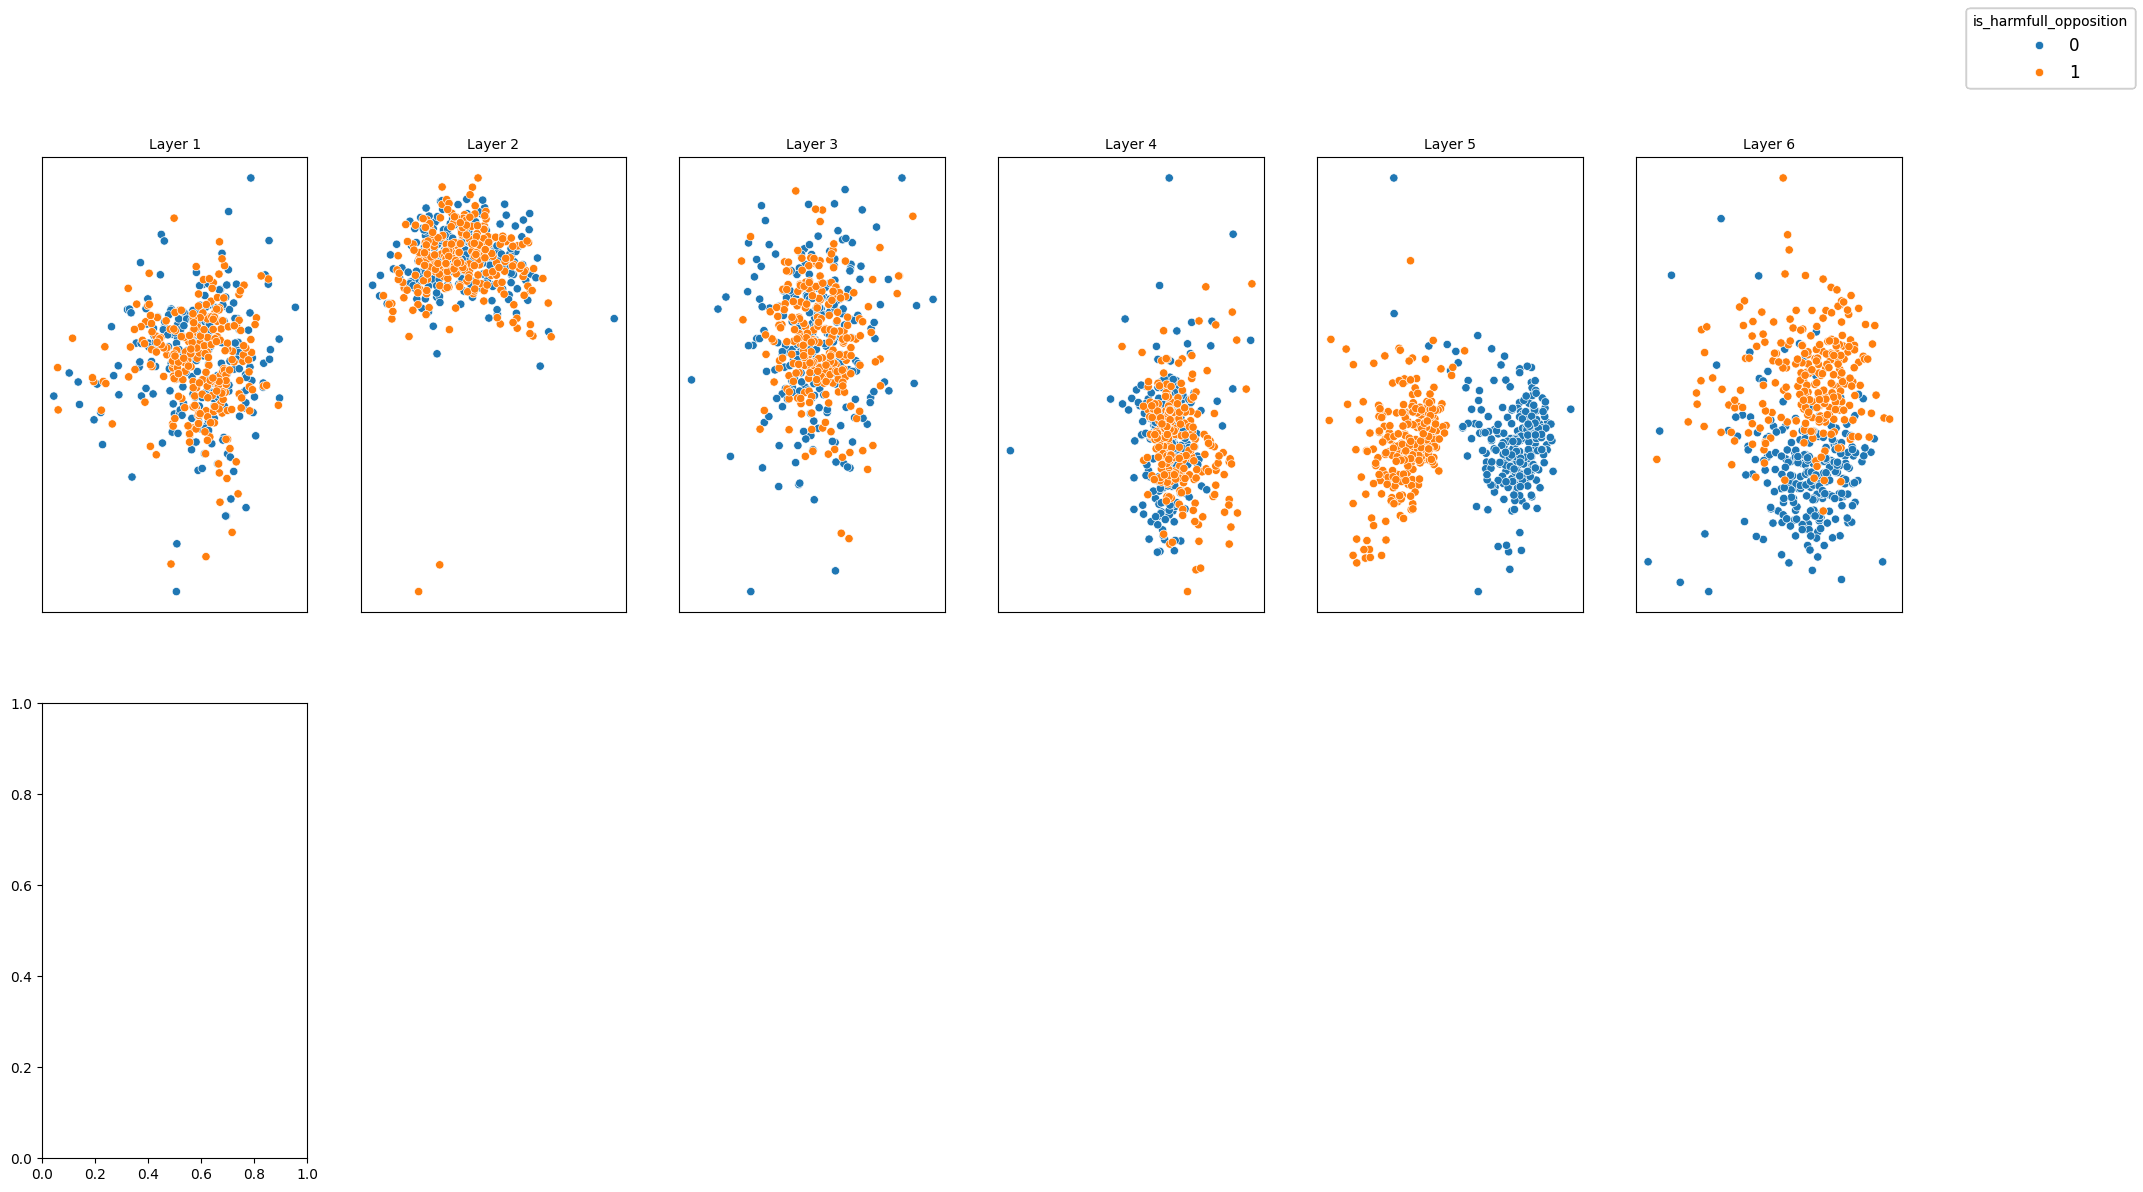

In [23]:
X_pos_st_normalized = X_pos_st.reshape(-1, X_pos_st.shape[-1])         # (512*25, 768)
X_pos_st_normalized = normalize(X_pos_st_normalized, norm='l2', axis=1).reshape(X_pos_st.shape)

X_neg_st_normalized = X_neg_st.reshape(-1, X_neg_st.shape[-1])         # (512*25, 768)
X_neg_st_normalized = normalize(X_neg_st_normalized, norm='l2', axis=1).reshape(X_neg_st.shape)

# Components 1, 3

plot_pca_or_tsne_layerwise(X_pos_st_normalized,
                           X_neg_st_normalized,
                           hate_data['is_harmfull_opposition'],
                           standardize=False,
                           n_components=5, components=[1, 3])

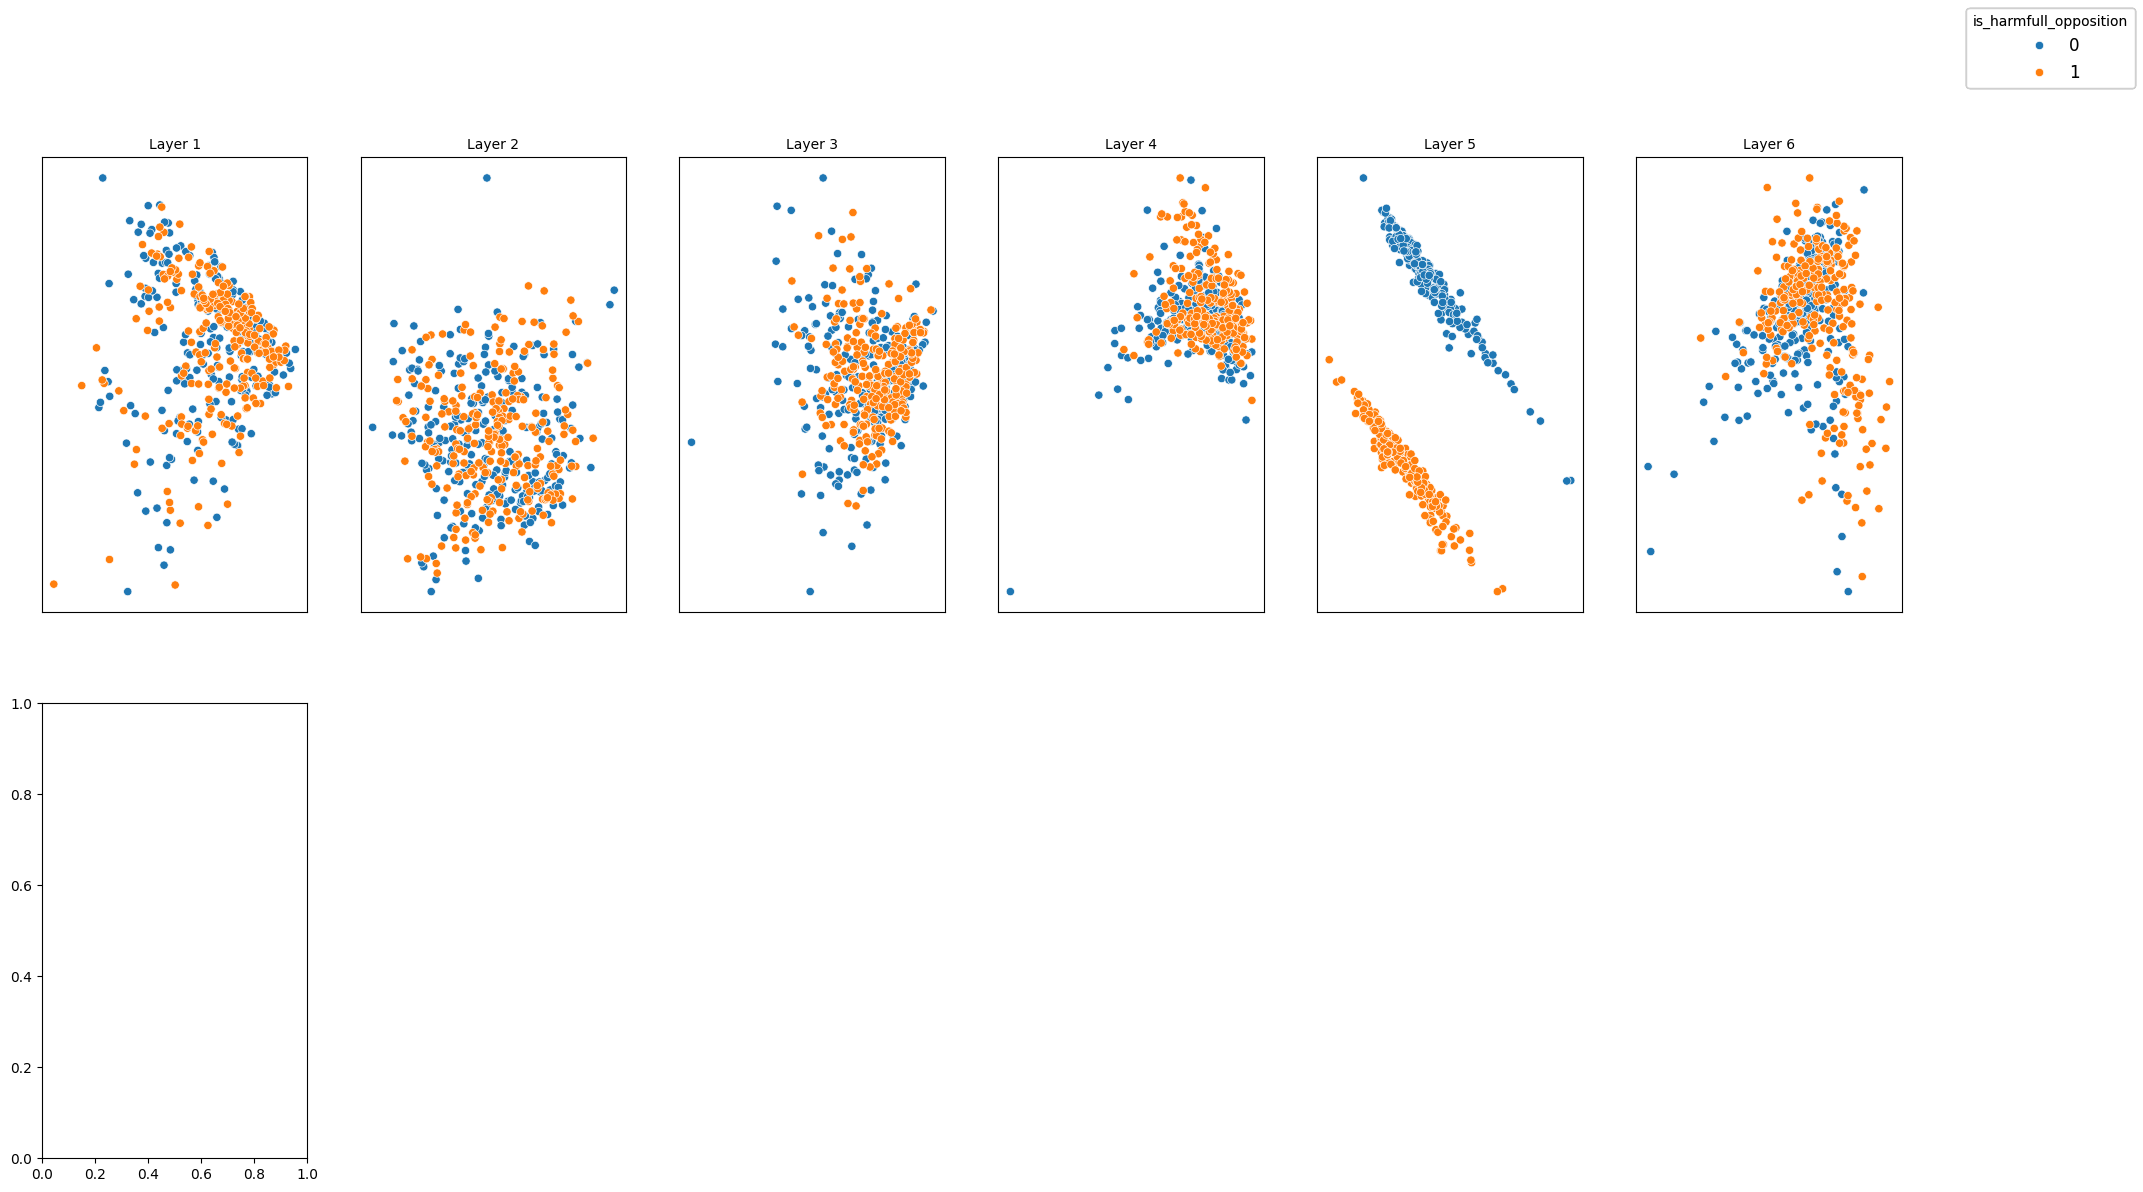

In [24]:
# Components 1, 0
plot_pca_or_tsne_layerwise(X_pos_st_normalized,
                           X_neg_st_normalized,
                           hate_data['is_harmfull_opposition'],
                           standardize=False,
                           n_components=5, components=[0, 1])

In [25]:
steered_ccs = train_ccs_on_hidden_states(X_pos_st_normalized,
                                        X_neg_st_normalized,
                                        hate_data['is_harmfull_opposition'],
                                         train_idx,
                                         test_idx,
                                        normalizing='median')

Median normalize used
Layer 1/7, CCS accuracy: 0.5384615384615384
Median normalize used
Layer 2/7, CCS accuracy: 0.5256410256410257
Median normalize used
Layer 3/7, CCS accuracy: 0.5512820512820513
Median normalize used
Layer 4/7, CCS accuracy: 0.5128205128205128
Median normalize used
Layer 5/7, CCS accuracy: 0.5512820512820513
Median normalize used
Layer 6/7, CCS accuracy: 1.0
Median normalize used
Layer 7/7, CCS accuracy: 0.7051282051282052


## **7. Plot results tables.**

In [26]:
from format_results import get_results_table

In [27]:
orig_ccs_data = get_results_table(orig_ccs)
st_ccs_data = get_results_table(steered_ccs)

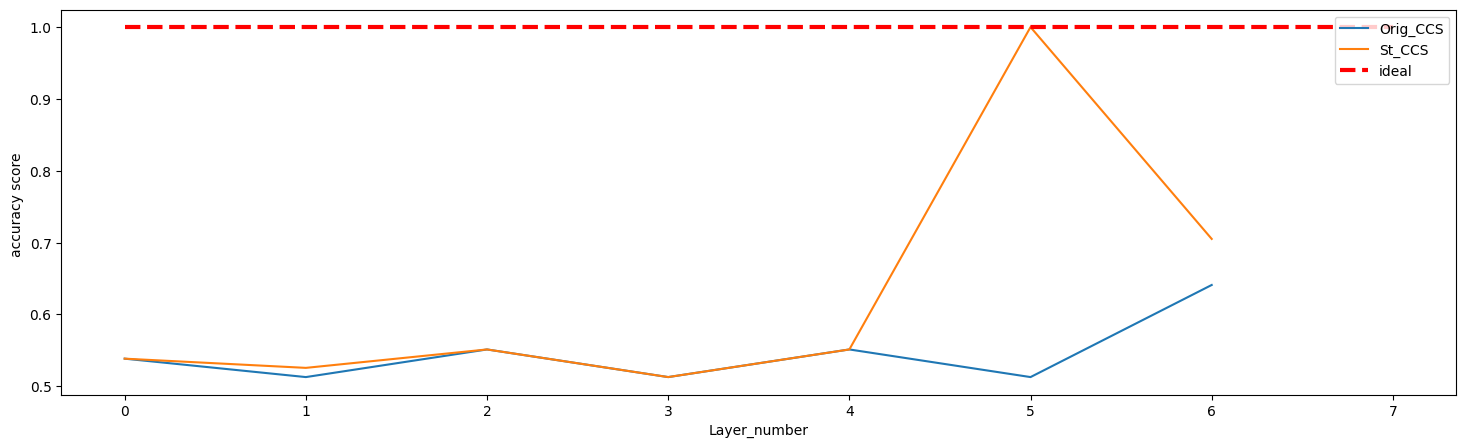

In [28]:
fig, ax = plt.subplots(figsize=(18, 5))

plt.plot(orig_ccs_data['accuracy'], label='Orig_CCS')
plt.plot(st_ccs_data['accuracy'], label='St_CCS')

plt.hlines(1, 0, 7, label='ideal', colors='red', linewidth=3, linestyles=['--'])

plt.xlabel('Layer_number')
plt.ylabel('accuracy score ')
plt.legend(loc='upper right');

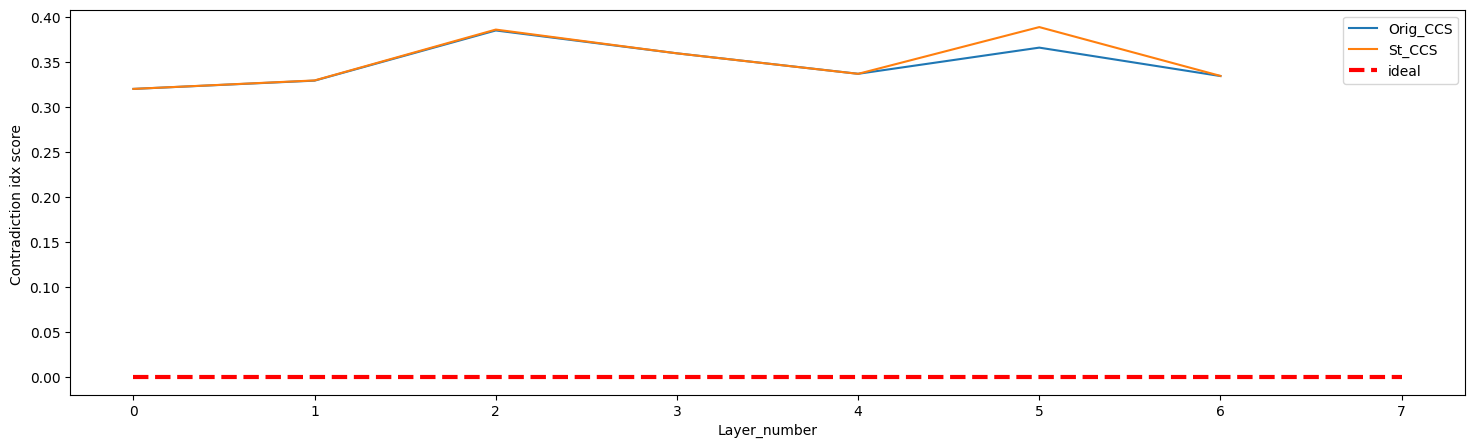

In [29]:
fig, ax = plt.subplots(figsize=(18, 5))

plt.plot(orig_ccs_data['contradiction_idx_↓'], label='Orig_CCS')
plt.plot(st_ccs_data['contradiction_idx_↓'], label='St_CCS')

plt.hlines(0, 0, 7, label='ideal', colors='red', linewidth=3, linestyles=['--'])

plt.xlabel('Layer_number')
plt.ylabel('Contradiction idx score ')
plt.legend(loc='upper right');

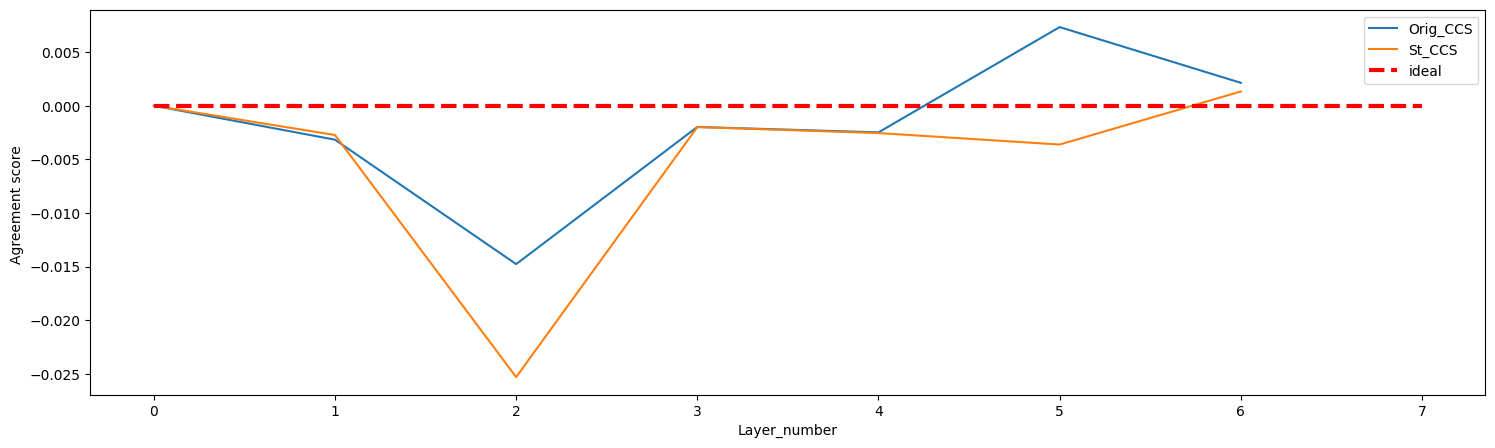

In [30]:
fig, ax = plt.subplots(figsize=(18, 5))

plt.plot(orig_ccs_data['agreement_score_↓'], label='Orig_CCS')
plt.plot(st_ccs_data['agreement_score_↓'], label='St_CCS')

plt.hlines(0, 0, 7, label='ideal', colors='red', linewidth=3, linestyles=['--'])

plt.xlabel('Layer_number')
plt.ylabel('Agreement score ')
plt.legend(loc='upper right');